In [1]:
import numpy as np
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d
from scipy.integrate import simps
ccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = False
import matplotlib

%matplotlib inline


print("CCL version you are using:",ccl.__version__)

CCL version you are using: 3.0.2


Set up font sizes, etc.

In [2]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

# 1. General halo model power spectra

## 1.1 tSZ power spectrum

True


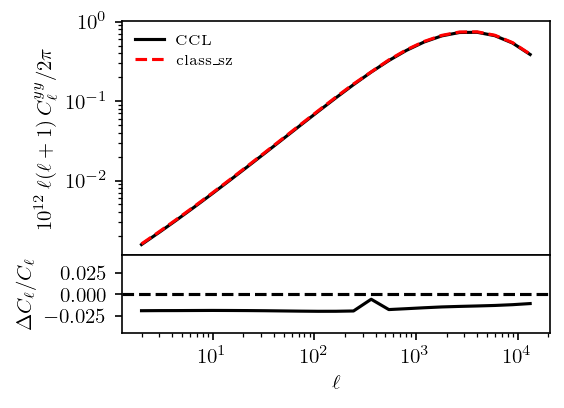

<Figure size 960x720 with 0 Axes>

In [3]:
# Benchmark power spectrum
d = np.loadtxt("../benchmarks/data/sz_cl_P13_szpowerspectrum.txt",
               unpack=True)
l_bm = d[0]
cl_bm = d[1]
# Ad-hoc prefactor often used when plotting the yy power spectrum
fac = l_bm*(l_bm+1)*1E12/(2*np.pi)

# Fiducial cosmological model
cosmo = ccl.Cosmology(
    Omega_b=0.05,
    Omega_c=0.25,
    h=0.7,
    n_s=0.9645,
    A_s=2.02E-9,
    Neff=3.046, T_CMB=2.725,
    transfer_function='boltzmann_class')

# Initialize halo model ingredients
mass_def = ccl.halos.MassDef(500, 'critical')
hmf = ccl.halos.MassFuncTinker08(mass_def=mass_def)
hbf = ccl.halos.HaloBiasTinker10(mass_def=mass_def)
hmc = ccl.halos.HMCalculator(mass_function=hmf, halo_bias=hbf,
                             mass_def=mass_def)
# Arnaud et al. pressure profile
prf = ccl.halos.HaloProfilePressureGNFW(mass_def=mass_def)
prf.update_parameters(mass_bias=1./1.41, x_out=6.)

# C_ell tracer
tr = ccl.tSZTracer(cosmo, z_max=3.)

# Halo model  power spectrum
# Note that we remove the 2-halo term for this particular comparison.
# The yy power spectrum is dominated by the 1-halo term, so the
# 2-halo term is often ignored.
pk = ccl.halos.halomod_Pk2D(cosmo, hmc, prf, get_2h=False)

# Angular power spectrum
cl = ccl.angular_cl(cosmo, tr, tr, ell=l_bm, p_of_k_a=pk)*fac

# Agrees to 2%
print(np.all(np.fabs(cl/cl_bm-1) < 2E-2))

# Plot
fig = plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(**plot_adjust)
ax1 = fig.add_axes((.1,.3,.8,.6))
ax2 = fig.add_axes((.1,.1,.8,.2))
ax1.plot(l_bm, cl, 'k-', label='CCL')
ax1.plot(l_bm, cl_bm, 'r--', label='class_sz')
ax1.set_ylabel(r'$10^{12}\,\ell(\ell+1)\,C_\ell^{yy}/2\pi$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xticklabels([])
ax1.legend(frameon=False, fontsize="x-small", ncol=1)
ax2.set_xlabel(r'$\ell$')
ax2.set_ylabel(r'$\Delta C_\ell/C_\ell$')
ax2.plot(l_bm, cl/cl_bm-1, 'k-')
ax2.set_xscale('log')
ax2.set_ylim([-0.045, 0.045])
ax2.axhline(0, ls='--', c='k')
plt.savefig('cl_yy.pdf', bbox_inches='tight')
plt.show()
plt.clf();

## 1.2 CIB power spectrum

True


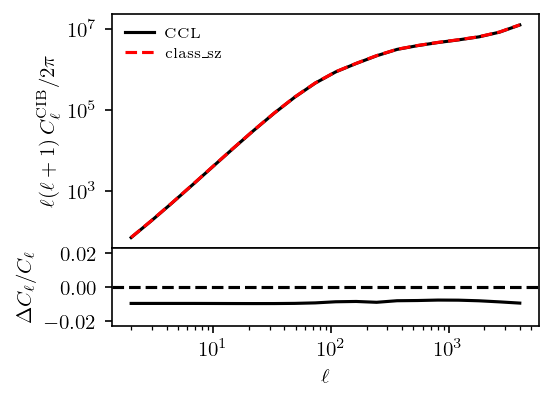

<Figure size 960x720 with 0 Axes>

In [4]:
# Read benchmarks
bm = np.loadtxt("../benchmarks/data/cib_class_sz_szpowerspectrum.txt",
                unpack=True)
l_bm = bm[0]
cl_bm = bm[31]+bm[32]
fac = l_bm*(l_bm+1)/(2*np.pi)

# Fiducial cosmological model
cosmo = ccl.Cosmology(Omega_b=0.05,
                      Omega_c=0.25,
                      h=0.7,
                      n_s=0.9645,
                      A_s=2.02E-9,
                      Neff=3.046, T_CMB=2.725)
mdef = ccl.halos.MassDef200m
cM = ccl.halos.ConcentrationDuffy08(mass_def=mdef)
nM = ccl.halos.MassFuncTinker10(mass_def=mdef, norm_all_z=True)
bM = ccl.halos.HaloBiasTinker10(mass_def=mdef)
hmc = ccl.halos.HMCalculator(mass_function=nM, halo_bias=bM,
                             mass_def=mdef)
# Halo profile
pr = ccl.halos.HaloProfileCIBShang12(concentration=cM, nu_GHz=217,
                                     Mmin=1E10, mass_def=mdef)
pr.update_parameters(nu_GHz=217,
                     alpha=0.36,
                     T0=24.4,
                     beta=1.75,
                     gamma=1.7,
                     s_z=3.6,
                     log10Meff=12.6,
                     siglog10M=np.sqrt(0.5),
                     Mmin=1E10,
                     L0=6.4E-8)
pr2pt = ccl.halos.Profile2ptCIB()

# C_ell tracer
tr = ccl.CIBTracer(cosmo, z_min=0.07)

# Halo model power spectrum
pk = ccl.halos.halomod_Pk2D(cosmo, hmc, pr, prof_2pt=pr2pt)

# Angular power spectrum
cl = ccl.angular_cl(cosmo, tr, tr, ell=l_bm, p_of_k_a=pk)*fac

# Agrees to 1%
print(np.all(np.fabs(cl/cl_bm-1) < 1E-2))

# Plot
fig = plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(**plot_adjust)
ax1 = fig.add_axes((.1,.3,.8,.6))
ax2 = fig.add_axes((.1,.1,.8,.2))
ax1.plot(l_bm, cl, 'k-', label='CCL')
ax1.plot(l_bm, cl_bm, 'r--', label='class_sz')
ax1.set_ylabel(r'$\ell(\ell+1)\,C_\ell^{\rm CIB}/2\pi$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xticklabels([])
ax1.legend(frameon=False, fontsize="x-small", ncol=1)
ax2.set_xlabel(r'$\ell$')
ax2.set_ylabel(r'$\Delta C_\ell/C_\ell$')
ax2.plot(l_bm, cl/cl_bm-1, 'k-')
ax2.set_xscale('log')
ax2.set_ylim([-0.023, 0.023])
ax2.axhline(0, ls='--', c='k')
plt.savefig('cl_cib.pdf', bbox_inches='tight')
plt.show()
plt.clf();

## 1.3 Halo Occupation Distribution

True


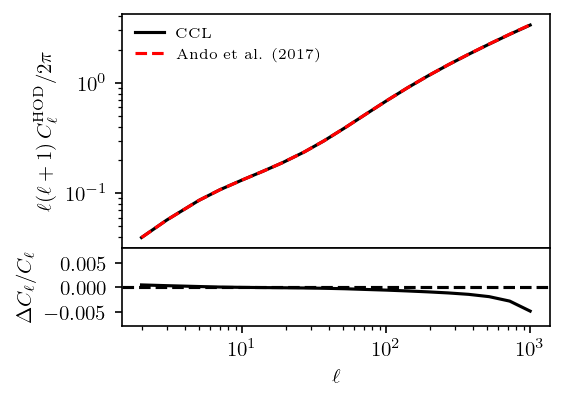

<Figure size 960x720 with 0 Axes>

In [5]:
# With many thanks to Ryu Makiya, Eiichiro Komatsu
# and Shin'ichiro Ando for providing this benchmark.
# Input power matter spectrum
# (ensuring we use the same in CCL)
ks = np.loadtxt("../benchmarks/data/k_hod.txt")
zs = np.loadtxt("../benchmarks/data/z_hod.txt")
pks = np.loadtxt("../benchmarks/data/pk_hod.txt")

# Benchmark C_ell
l_bm, cl_bm = np.loadtxt("../benchmarks/data/cl_hod.txt",
                         unpack=True)
fac = l_bm*(l_bm+1)/(2*np.pi)
cl_bm *= fac

# HOD params
log10Mcut = 11.8
log10M1 = 11.73
sigma_Ncen = 0.15
alp_Nsat = 0.77
rmax = 4.39
rgs = 1.17

# Set N(z)
def _nz_2mrs(z):
    # From 1706.05422
    m = 1.31
    beta = 1.64
    x = z / 0.0266
    return x**m * np.exp(-x**beta)
z1 = 1e-5
z2 = 0.1
z_arr = np.linspace(z1, z2, 1024)
dndz = _nz_2mrs(z_arr)

# CCL prediction
# Make sure we use the same P(k)
cosmo = ccl.CosmologyCalculator(
    Omega_b=0.05,
    Omega_c=0.25,
    h=0.67,
    n_s=0.9645,
    A_s=2.0E-9,
    m_nu=0.00001,
    mass_split='equal',
    pk_linear={'a': 1./(1.+zs[::-1]),
               'k': ks,
               'delta_matter:delta_matter': pks[::-1, :]})
cosmo.compute_growth()

# Halo model setup
mass_def = ccl.halos.MassDef(200, 'critical')
cm = ccl.halos.ConcentrationDuffy08(mass_def=mass_def)
hmf = ccl.halos.MassFuncTinker08(mass_def=mass_def)
hbf = ccl.halos.HaloBiasTinker10(mass_def=mass_def)
hmc = ccl.halos.HMCalculator(mass_function=hmf, halo_bias=hbf,
                             mass_def=mass_def)
prf = ccl.halos.HaloProfileHOD(
    mass_def=mass_def,
    concentration=cm,
    log10Mmin_0=np.log10(10.**log10Mcut/cosmo['h']),
    siglnM_0=sigma_Ncen,
    log10M0_0=np.log10(10.**log10Mcut/cosmo['h']),
    log10M1_0=np.log10(10.**log10M1/cosmo['h']),
    alpha_0=alp_Nsat,
    bg_0=rgs,
    bmax_0=rmax)
prf2pt = ccl.halos.Profile2ptHOD()
# P(k)
a_arr, lk_arr, _ = cosmo.get_linear_power().get_spline_arrays()
pk_hod = ccl.halos.halomod_Pk2D(cosmo, hmc, prf, prof_2pt=prf2pt,
                                lk_arr=lk_arr, a_arr=a_arr)
# C_ell
tr = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_arr, dndz),
                            bias=(z_arr, np.ones(len(dndz))))
cl = ccl.angular_cl(cosmo, tr, tr, ell=l_bm, p_of_k_a=pk_hod)*fac

# Agrees to 0.5%
print(np.all(np.fabs(cl/cl_bm-1) < 0.005))

# Plot
fig = plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(**plot_adjust)
ax1 = fig.add_axes((.1,.3,.8,.6))
ax2 = fig.add_axes((.1,.1,.8,.2))
ax1.plot(l_bm, cl, 'k-', label='CCL')
ax1.plot(l_bm, cl_bm, 'r--', label='Ando et al. (2017)')
ax1.set_ylabel(r'$\ell(\ell+1)\,C_\ell^{\rm HOD}/2\pi$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xticklabels([])
ax1.legend(frameon=False, fontsize="x-small", ncol=1)
ax2.set_xlabel(r'$\ell$')
ax2.set_ylabel(r'$\Delta C_\ell/C_\ell$')
ax2.plot(l_bm, cl/cl_bm-1, 'k-')
ax2.set_xscale('log')
ax2.set_ylim([-0.008, 0.008])
ax2.axhline(0, ls='--', c='k')
plt.savefig('cl_hod.pdf', bbox_inches='tight')
plt.show()
plt.clf();

## 1.4 Satellite alignment HOD

True
True


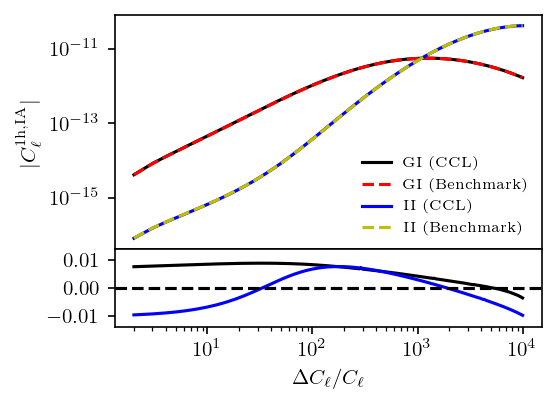

<Figure size 960x720 with 0 Axes>

In [6]:
# An in-house benchmark test has been developed, testing the accuracy
# of the FFTLog method against a highly accurate integration method as
# described in benchmarks/data/codes/halomod_IA_FFTLog_accuracy.ipynb.
l_arr, cl_GI_benchmark, cl_II_benchmark = np.loadtxt(
    '../benchmarks/data/IA_halomodel_Cell_test.txt',
    delimiter=',', unpack=True)
A_IA = 1.0
cl_GI_benchmark *= A_IA
cl_II_benchmark *= A_IA**2

cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045,
                      h=0.67, sigma8=0.83, n_s=0.96)
k_arr = np.geomspace(1E-3, 1e2, 128)  # For evaluating
a_arr = np.linspace(0.1, 1, 16)

cM = ccl.halos.ConcentrationDuffy08(mass_def="200m")
nM = ccl.halos.MassFuncTinker08(mass_def="200m")
bM = ccl.halos.HaloBiasTinker10(mass_def="200m")
hmc = ccl.halos.HMCalculator(mass_function=nM,
                             halo_bias=bM,
                             mass_def="200m", nM=64)

sat_gamma_HOD = ccl.halos.SatelliteShearHOD(concentration=cM,
                                            mass_def='200m')
NFW = ccl.halos.HaloProfileNFW(concentration=cM, truncated=True,
                               fourier_analytic=True, mass_def='200m')

pk_GI_1h = ccl.halos.halomod_Pk2D(cosmo, hmc, NFW,
                                  prof2=sat_gamma_HOD,
                                  get_2h=False,
                                  lk_arr=np.log(k_arr),
                                  a_arr=a_arr)
pk_II_1h = ccl.halos.halomod_Pk2D(cosmo, hmc, sat_gamma_HOD,
                                  get_2h=False,
                                  lk_arr=np.log(k_arr),
                                  a_arr=a_arr)

z_arr = np.linspace(0., 3., 256)
z0 = 0.1
pz = 1. / (2. * z0) * (z_arr / z0) ** 2. * np.exp(-z_arr / z0)

b_IA = A_IA*np.ones(len(z_arr))                                                                                                                                                                                                                     
ia_tracer = ccl.WeakLensingTracer(cosmo, dndz=(z_arr, pz), has_shear=False,
                                  ia_bias=(z_arr, b_IA), use_A_ia=False)
wl_tracer = ccl.WeakLensingTracer(cosmo, dndz=(z_arr, pz))

cl_GI_1h = ccl.angular_cl(cosmo, wl_tracer, ia_tracer, l_arr,
                          p_of_k_a=pk_GI_1h)
cl_II_1h = ccl.angular_cl(cosmo, ia_tracer, ia_tracer, l_arr,
                          p_of_k_a=pk_II_1h)

print(np.all(np.fabs(cl_GI_1h / cl_GI_benchmark - 1) < 0.01))
print(np.all(np.fabs(cl_II_1h / cl_II_benchmark - 1) < 0.02))

# Plot
fig = plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(**plot_adjust)
ax1 = fig.add_axes((.1,.3,.8,.6))
ax2 = fig.add_axes((.1,.1,.8,.2))
ax1.plot(l_arr, -cl_GI_1h, 'k-', label=r'GI (CCL)')
ax1.plot(l_arr, -cl_GI_benchmark, 'r--', label=r'GI (Benchmark)')
ax1.plot(l_arr, cl_II_1h, 'b-', label='II (CCL)')
ax1.plot(l_arr, cl_II_benchmark, 'y--', label='II (Benchmark)')
ax1.set_ylabel(r'$|C^{\rm 1h,IA}_\ell|$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xticklabels([])
ax1.legend(frameon=False, fontsize="x-small", ncol=1)
ax2.set_xlabel(r'$\ell$')
ax2.set_xlabel(r'$\Delta C_\ell/C_\ell$')
ax2.plot(l_arr, cl_GI_1h/cl_GI_benchmark-1, 'k-')
ax2.plot(l_arr, cl_II_1h/cl_II_benchmark-1, 'b-')
ax2.set_xscale('log')
ax2.set_ylim([-0.014, 0.014])
ax2.axhline(0, ls='--', c='k')
plt.savefig('cl_IA.pdf', bbox_inches='tight')
plt.show()
plt.clf();

# 2. New $C_\ell$ tracers

True


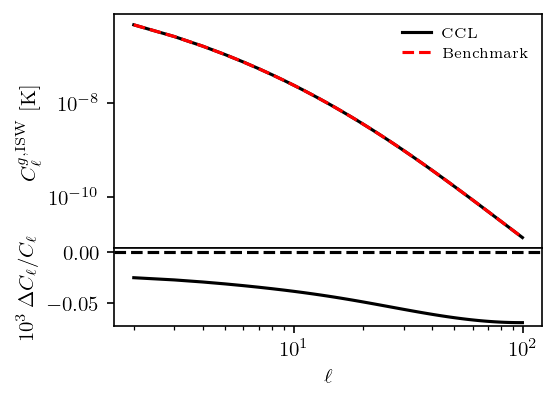

<Figure size 960x720 with 0 Axes>

In [7]:
# Cosmology
Oc = 0.25
Ob = 0.05
h = 0.7
cosmo = ccl.Cosmology(
    Omega_b=Oc,
    Omega_c=Ob,
    h=h,
    n_s=0.96,
    sigma8=0.8,
    transfer_function='bbks')

# CCL calculation
ls = np.arange(2, 100)
zs = np.linspace(0, 0.6, 256)
nz = np.exp(-0.5*((zs-0.3)/0.05)**2)
bz = np.ones_like(zs)
tr_n = ccl.NumberCountsTracer(cosmo, has_rsd=False,
                              dndz=(zs, nz), bias=(zs, bz))
tr_i = ccl.ISWTracer(cosmo)
cl = ccl.angular_cl(cosmo, tr_n, tr_i, ls)

# Benchmark from Eq. 6 in 1710.03238
pz = nz / simps(nz, x=zs)
H0 = h / ccl.physical_constants.CLIGHT_HMPC
# Prefactor
prefac = 3*cosmo['T_CMB']*(Oc+Ob)*H0**3/(ls+0.5)**2
# H(z)/H0
ez = ccl.h_over_h0(cosmo, 1./(1+zs))
# Linear growth and derivative
dz = ccl.growth_factor(cosmo, 1./(1+zs))
gz = np.gradient(dz*(1+zs), zs[1]-zs[0])/dz
# Comoving distance
chi = ccl.comoving_radial_distance(cosmo, 1/(1+zs))
# P(k)
pks = np.array([ccl.nonlin_matter_power(cosmo, (ls+0.5)/(c+1E-6), 1./(1+z))
                for c, z in zip(chi, zs)]).T
# Limber integral
cl_int = pks[:, :]*(pz*ez*gz)[None, :]
clbb = simps(cl_int, x=zs)
clbb *= prefac

print(np.all(np.fabs(cl/clbb-1) < 1E-3))

# Plot
fig = plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(**plot_adjust)
ax1 = fig.add_axes((.1,.3,.8,.6))
ax2 = fig.add_axes((.1,.1,.8,.2))
ax1.plot(ls, cl, 'k-', label=r'CCL')
ax1.plot(ls, clbb, 'r--', label=r'Benchmark')
ax1.set_ylabel(r'$C^{g,{\rm ISW}}_\ell\,\,[{\rm K}]$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xticklabels([])
ax1.legend(frameon=False, fontsize="x-small", ncol=1)
ax2.set_xlabel(r'$\ell$')
ax2.set_ylabel(r'$10^3\,\Delta C_\ell/C_\ell$')
ax2.plot(ls, 1E3*(cl/clbb-1), 'k-')
ax2.set_xscale('log')
ax2.axhline(0, ls='--', c='k')
plt.savefig('cl_ISW.pdf', bbox_inches='tight')
plt.show()
plt.clf();

# 3. Covariances

## 3.1 1-halo trispectrum

True


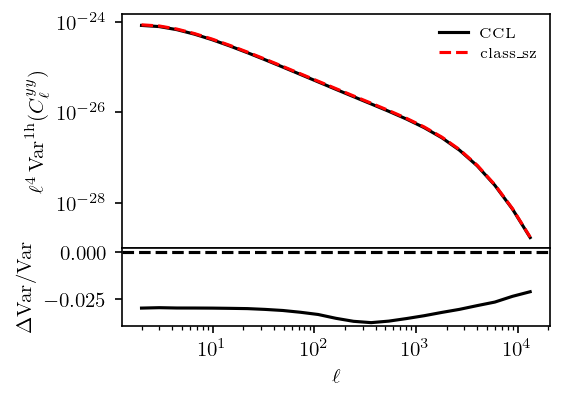

<Figure size 960x720 with 0 Axes>

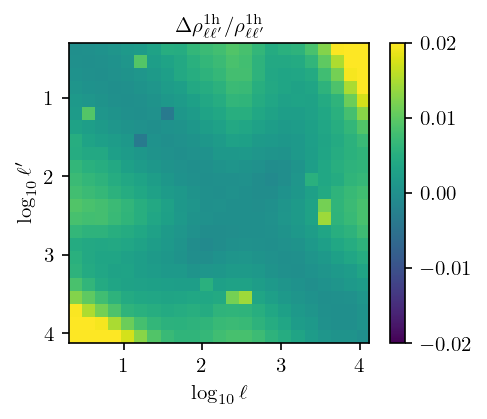

<Figure size 960x720 with 0 Axes>

In [8]:
# Read benchmark
fsky = 1.
l_bm = np.loadtxt("../benchmarks/data/sz_cl_P13_szpowerspectrum.txt",
                  unpack=True)[0]
tll_bm = np.loadtxt("../benchmarks/data/tSZ_trispectrum_ref_for_cobaya.txt")
fac = 2*np.pi/(l_bm*(l_bm+1)*1E12)
tll_bm *= fac[:, None]*fac[None, :]/(4*np.pi*fsky)

# Cosmology
cosmo = ccl.Cosmology(
    Omega_b=0.05,
    Omega_c=0.25,
    h=0.7,
    n_s=0.9645,
    A_s=2.02E-9,
    Neff=3.046, T_CMB=2.725,
    transfer_function='boltzmann_class')

# Halo model ingredients
mass_def = ccl.halos.MassDef(500, 'critical')
hmf = ccl.halos.MassFuncTinker08(mass_def=mass_def)
hbf = ccl.halos.HaloBiasTinker10(mass_def=mass_def)
hmc = ccl.halos.HMCalculator(mass_function=hmf, halo_bias=hbf,
                             mass_def=mass_def)

# Arnaud pressure profile
prf = ccl.halos.HaloProfilePressureGNFW(mass_def=mass_def)
prf.update_parameters(mass_bias=1./1.41, x_out=6.)

# C_ell tracer
tr = ccl.tSZTracer(cosmo, z_max=3.)

# 3D trispectrum
lk_arr = np.log(np.geomspace(1E-4, 1E2, 256))
a_arr = 1./(1+np.linspace(0, 3., 20))[::-1]
tkk = ccl.halos.halomod_Tk3D_1h(cosmo, hmc, prf,
                                lk_arr=lk_arr, a_arr=a_arr,
                                use_log=True)

# Limber projection
tll = ccl.angular_cl_cov_cNG(cosmo, tr, tr, ell=l_bm, t_of_kk_a=tkk,
                             fsky=fsky)
print(np.all(np.fabs(tll/tll_bm-1) < 5E-2))


rll = tll/np.sqrt(np.outer(np.diag(tll), np.diag(tll)))
rll_bm = tll_bm/np.sqrt(np.outer(np.diag(tll_bm), np.diag(tll_bm)))

# Plot
fig = plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(**plot_adjust)
ax1 = fig.add_axes((.1,.3,.8,.6))
ax2 = fig.add_axes((.1,.1,.8,.2))
ax1.plot(l_bm, l_bm**4*np.diag(tll), 'k-', label=r"CCL")
ax1.plot(l_bm, l_bm**4*np.diag(tll_bm), 'r--', label=r"class_sz")
ax1.set_ylabel(r"$\ell^4\,{\rm Var}^{\rm 1h}(C_\ell^{yy})$")
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xticklabels([])
ax1.legend(frameon=False, fontsize="x-small", ncol=1)
ax2.set_xlabel(r'$\ell$')
ax2.set_ylabel(r'$\Delta {\rm Var}/{\rm Var}$')
ax2.plot(l_bm, (np.diag(tll)/np.diag(tll_bm)-1), 'k-')
ax2.set_xscale('log')
ax2.axhline(0, ls='--', c='k')
plt.savefig('tll_1h.pdf', bbox_inches='tight')
plt.show()
plt.clf();

plt.figure(figsize=fig_size)
llmin = np.log10(l_bm)[0]
llmax = np.log10(l_bm)[-1]
plt.title(r"$\Delta\rho^{\rm 1h}_{\ell\ell'}/\rho^{\rm 1h}_{\ell\ell'}$")
plt.imshow((rll/rll_bm-1), extent=[llmin, llmax, llmax, llmin], vmin=-0.02, vmax=0.02)
plt.xlabel(r"$\log_{10}\ell$")
plt.ylabel(r"$\log_{10}\ell'$")
plt.colorbar()
plt.savefig('rll_1h.pdf', bbox_inches='tight')
plt.show()
plt.clf();

## 3.2 SSC

True


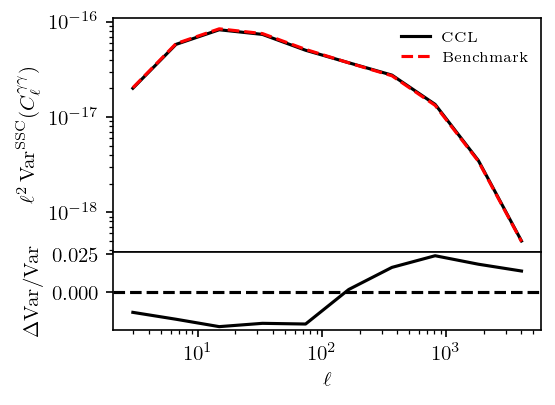

<Figure size 960x720 with 0 Axes>

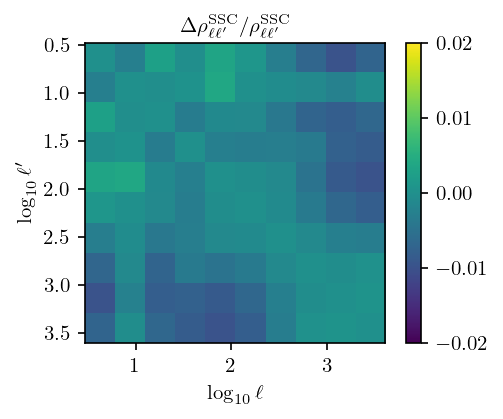

<Figure size 960x720 with 0 Axes>

In [9]:
# Compare against Benjamin Joachimi's code. An overview of the methodology
# is given in appendix E.2 of 2007.01844.

h = 0.7
cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=h, n_s=0.97,
                      sigma8=0.8, m_nu=0.0)

mass_def = ccl.halos.MassDef200m
hmf = ccl.halos.MassFuncTinker10(mass_def=mass_def)
hbf = ccl.halos.HaloBiasTinker10(mass_def=mass_def)
con = ccl.halos.ConcentrationDuffy08(mass_def=mass_def)
nfw = ccl.halos.HaloProfileNFW(mass_def=mass_def, concentration=con,
                               fourier_analytic=True)
hmc = ccl.halos.HMCalculator(mass_function=hmf, halo_bias=hbf,
                             mass_def=mass_def)

n_z = 100
n_k = 200
k_min = 1e-4
k_max = 1e2

a = np.linspace(1/(1+6), 1, n_z)
k = np.geomspace(k_min, k_max, n_k)

tk3D = ccl.halos.halomod_Tk3D_SSC(cosmo=cosmo, hmc=hmc,
                                  prof=nfw, prof2=nfw, prof12_2pt=None,
                                  lk_arr=np.log(k), a_arr=a,
                                  use_log=True)

z, nofz = np.loadtxt("../benchmarks/data/covariances/ssc_WL_nofz.txt",
                     unpack=True)
WL_tracer = ccl.WeakLensingTracer(cosmo, dndz=(z, nofz))

ell = np.loadtxt("../benchmarks/data/covariances/ssc_WL_ell.txt")

fsky = 0.05

sigma2_B = ccl.sigma2_B_disc(cosmo, a_arr=a, fsky=fsky)
cov_ssc = ccl.covariances.angular_cl_cov_SSC(cosmo,
                                             tracer1=WL_tracer,
                                             tracer2=WL_tracer,
                                             ell=ell, t_of_kk_a=tk3D,
                                             sigma2_B=(a, sigma2_B),
                                             fsky=None)
var_ssc_ccl = np.diag(cov_ssc)
off_diag_1_ccl = np.diag(cov_ssc, k=1)

cov_ssc_bj = np.loadtxt("../benchmarks/data/covariances/ssc_WL_cov_matrix.txt")

# At large scales, CCL uses a different convention for the Limber                                                                                                                                                                                                           
# approximation. This factor accounts for this difference                                                                                                                                                                                                                   
ccl_limber_shear_fac = np.sqrt((ell-1)*ell*(ell+1)*(ell+2))/(ell+1/2)**2
cov_ssc_bj_corrected = cov_ssc_bj * np.outer(ccl_limber_shear_fac**2,
                                             ccl_limber_shear_fac**2)
var_bj = np.diag(cov_ssc_bj_corrected)
off_diag_1_bj = np.diag(cov_ssc_bj_corrected, k=1)

print(np.all(np.fabs(cov_ssc/cov_ssc_bj_corrected - 1) < 3e-2))

rll = cov_ssc/np.sqrt(np.outer(np.diag(cov_ssc), np.diag(cov_ssc)))
rll_bm = cov_ssc_bj_corrected/np.sqrt(np.outer(np.diag(cov_ssc_bj_corrected), np.diag(cov_ssc_bj_corrected)))
l_bm = ell

# Plot
fig = plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(**plot_adjust)
ax1 = fig.add_axes((.1,.3,.8,.6))
ax2 = fig.add_axes((.1,.1,.8,.2))
ax1.plot(l_bm, l_bm**2*np.diag(cov_ssc), 'k-', label=r"CCL")
ax1.plot(l_bm, l_bm**2*np.diag(cov_ssc_bj_corrected), 'r--', label=r"Benchmark")
ax1.set_ylabel(r"$\ell^2\,{\rm Var}^{\rm SSC}(C_\ell^{\gamma\gamma})$")
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xticklabels([])
ax1.legend(frameon=False, fontsize="x-small", ncol=1)
ax2.set_xlabel(r'$\ell$')
ax2.set_ylabel(r'$\Delta {\rm Var}/{\rm Var}$')
ax2.plot(l_bm, (np.diag(cov_ssc)/np.diag(cov_ssc_bj_corrected)-1), 'k-')
ax2.set_xscale('log')
ax2.axhline(0, ls='--', c='k')
plt.savefig('tll_SSC.pdf', bbox_inches='tight')
plt.show()
plt.clf();

plt.figure(figsize=fig_size)
llmin = np.log10(l_bm)[0]
llmax = np.log10(l_bm)[-1]
plt.title(r"$\Delta\rho^{\rm SSC}_{\ell\ell'}/\rho^{\rm SSC}_{\ell\ell'}$")
plt.imshow((rll/rll_bm-1), extent=[llmin, llmax, llmax, llmin], vmin=-0.02, vmax=0.02)
plt.xlabel(r"$\log_{10}\ell$")
plt.ylabel(r"$\log_{10}\ell'$")
plt.colorbar()
plt.savefig('rll_SSC.pdf', bbox_inches='tight')
plt.show()
plt.clf();